In [18]:
# -*- coding: utf-8 -*-

from matplotlib import pyplot as plt
import os
import cv2
import numpy as np

# Elements of those lists will be displayed in windows
processed_images = []


def loadImages():
    images = []
    main_dir = 'photos'
    for directory in os.listdir(main_dir):
        for file_name in os.listdir(main_dir + '/' + directory):
            file_path = main_dir + '/' + directory + '/' + file_name
            images.append(cv2.imread(file_path))
    print('All images loaded')
    return images


def loadImage():
    images = []
    images.append(cv2.imread("big field.png"))
    print('All images loaded')
    return images


def drawContourOnImage(image, contour):
    cv2.drawContours(image, [contour], -1, 255, cv2.FILLED)
    return image


def thresholdBetweenValues(image, thresh_min, thresh_max):
    # Finding two thresholds and then finding the common part
    _, threshold = cv2.threshold(image, thresh_min, 255, cv2.THRESH_BINARY)
    _, threshold2 = cv2.threshold(
        image, thresh_max, 255, cv2.THRESH_BINARY_INV)
    return cv2.bitwise_and(threshold, threshold2)


def thresholdInRange(image, threshold_range):
    return thresholdBetweenValues(image, threshold_range[0], threshold_range[1])


def findBackground(image):
    h, s, v = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    blue = [0.5 * 180, 0.65 * 180]
    background = thresholdInRange(h, blue)
    background = cv2.morphologyEx(
        background, cv2.MORPH_DILATE, np.ones((7, 7), np.uint8))
    contours, hierarchy = cv2.findContours(
        background, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    # Find two biggest contours
    max_area_index = 0
    second_max_area_index = 0
    max_area = 0
    second_max_area = 0
    for i, cont in enumerate(contours):
        tmp_area = cv2.contourArea(cont)
        if tmp_area > max_area:
            second_max_area = max_area
            second_max_area_index = max_area_index
            max_area = tmp_area
            max_area_index = i
        elif tmp_area > second_max_area:
            second_max_area = tmp_area
            second_max_area_index = i

    # Największym konturem jest prawie zawsze cała plansza.
    # Drugim co do wielkości jest plansza z wyciętą wodą, która by nas bardziej interesowała.
    # Jednak na niektórych zdjęciach oba te kontury się zlewają w jeden, więc nie możemy zawsze brać tego mniejszego.
    # If the second biggest contour is inside the biggest one take the inside one
    if hierarchy[0][second_max_area_index][3] == max_area_index:
        best_contour = contours[second_max_area_index]
    else:
        best_contour = contours[max_area_index]
    return best_contour


def cutBackground(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)


def findRedPieces(data):
    h, s, v = cv2.split(cv2.cvtColor(data, cv2.COLOR_BGR2HSV))
    h_new = [0.04 * 180, 0.93 * 180]
    s_new = [0.5 * 255, 1 * 255]
    v_new = [0 * 255, 1 * 255]
    _, threshold = cv2.threshold(h, h_new[0], 255, cv2.THRESH_BINARY_INV)
    _, threshold2 = cv2.threshold(h, h_new[1], 255, cv2.THRESH_BINARY)
    background1 = cv2.bitwise_xor(threshold, threshold2)
    background2 = thresholdInRange(s, s_new)
    background3 = thresholdInRange(v, v_new)
    background = cv2.bitwise_and(background1, background2, background3)
    background = cv2.morphologyEx(
        background, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8))
    return background


def findBluePieces(data):
    h, s, v = cv2.split(cv2.cvtColor(data, cv2.COLOR_BGR2HSV))
    h_new = [0.58 * 180, 0.69 * 180]
    s_new = [0.3 * 255, 1 * 255]
    v_new = [0 * 255, 0.6 * 255]
    background1 = thresholdInRange(h, h_new)
    background2 = thresholdInRange(s, s_new)
    background3 = thresholdInRange(v, v_new)
    background = cv2.bitwise_and(background1, background2, background3)
    background = cv2.morphologyEx(
        background, cv2.MORPH_ERODE, np.ones((6, 6), np.uint8))
    background = cv2.morphologyEx(
        background, cv2.MORPH_DILATE, np.ones((8, 8), np.uint8))
    return background


def findOrangePieces(data):
    h, s, v = cv2.split(cv2.cvtColor(data, cv2.COLOR_BGR2HSV))
    h_new = [0.05 * 180, 0.1 * 180]
    s_new = [0.8 * 255, 1 * 255]
    v_new = [0.85 * 255, 1 * 255]
    background1 = thresholdInRange(h, h_new)
    background2 = thresholdInRange(s, s_new)
    background3 = thresholdInRange(v, v_new)
    background = cv2.bitwise_and(background1, background2, background3)
    background = cv2.morphologyEx(
        background, cv2.MORPH_CLOSE, np.ones((11, 11), np.uint8))
    return background


def identifyPieces(image, pieces_mask, piece_color, red_limit=4000, blue_limit=2500, orange_limit=3000):
    if piece_color == 'red':
        pieces_colors = [(0, 0, 255), (255, 125, 255)]
        limit = red_limit  # w przypadku czerwonego koloru nie możemy pozwolić, aby uznawał czerwone cyfry na kółkach jako pionki
    elif piece_color == 'blue':
        pieces_colors = [(255, 0, 0), (255, 255, 0)]
        limit = blue_limit
    else:
        pieces_colors = [(0, 110, 255), (80, 165, 255)]
        limit = orange_limit  # czasem znajduje pomarańcz na polach ze zbożem
    contours, hierarchy = cv2.findContours(
        pieces_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for i, cont in enumerate(contours):
        hull = cv2.convexHull(cont)
        hull_area = cv2.contourArea(hull)
        if limit < hull_area < 15000:
            # red_mask = cv2.drawContours(red_mask, [hull], -1, 255, cv2.FILLED)
            try:
                ellipse = cv2.fitEllipse(hull)
            except cv2.error:  # Za mały kontur aby wpasować elipsę
                continue
            (x, y), (Ma, ma), angle = ellipse
            M = cv2.moments(hull)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            if Ma / ma > 0.8:  # Jeśli osie elipsy są prawie równe mamy okrąg
                cv2.rectangle(image, (cX - 35, cY - 35),
                              (cX + 35, cY + 35), pieces_colors[0], -1)
                cv2.rectangle(image, (cX - 30, cY - 30),
                              (cX + 30, cY + 30), pieces_colors[1], -1)
            else:  # Obiekt jest podłużny
                diamond = np.array(
                    [[[cX - 20, cY], [cX, cY + 30], [cX + 20, cY], [cX, cY - 30]]], np.int32)
                cv2.fillConvexPoly(image, diamond, pieces_colors[1])
                cv2.polylines(image, diamond, True, pieces_colors[0], 5)

            # cv2.drawContours(image, [hull], -1, color, cv2.FILLED)
        elif 15000 < hull_area < 50000:  # Jeśli kontur jest za duży, to być może dwa pionki się złączyły
            new_mask = np.zeros(image.shape[:2], dtype=np.uint8)
            new_mask = cv2.drawContours(new_mask, [cont], -1, 255, cv2.FILLED)
            new_mask = cv2.morphologyEx(
                new_mask, cv2.MORPH_ERODE, np.ones((5, 5), np.uint8))
            image = identifyPieces(
                image, new_mask, piece_color, limit-500, limit-500, limit)
    return image


def findTerrain(rawData, data, color, h_new, s_new, v_new, ile, ktory):
    h, s, v = cv2.split(cv2.cvtColor(data, cv2.COLOR_BGR2HSV))
    # Według wiki pola w Catanie to: brick, lumber, wool, grain, ore, desert
    if ktory == 'ore':
        _, threshold = cv2.threshold(
            h, h_new[0] * 180, 180, cv2.THRESH_BINARY_INV)
        _, threshold2 = cv2.threshold(
            h, h_new[1] * 180, 180, cv2.THRESH_BINARY)
        background1 = cv2.bitwise_xor(threshold, threshold2)
    else:
        background1 = thresholdBetweenValues(h, h_new[0] * 180, h_new[1] * 180)
    background2 = thresholdBetweenValues(s, s_new[0] * 255, s_new[1] * 255)
    background3 = thresholdBetweenValues(v, v_new[0] * 255, v_new[1] * 255)
    background = cv2.bitwise_and(background1, background2, background3)
    if ktory == 'desert':
        background = cv2.morphologyEx(
            background, cv2.MORPH_ERODE, np.ones((85, 85), np.uint8))
        background = cv2.morphologyEx(
            background, cv2.MORPH_DILATE, np.ones((30, 30), np.uint8))
    elif ktory == 'ore':
        background = cv2.morphologyEx(
            background, cv2.MORPH_ERODE, np.ones((10, 10), np.uint8))
        background = cv2.morphologyEx(
            background, cv2.MORPH_DILATE, np.ones((70, 70), np.uint8))
    elif ktory != 'grain':
        background = cv2.morphologyEx(
            background, cv2.MORPH_ERODE, np.ones((5, 5), np.uint8))
    contours, hierarchy = cv2.findContours(
        background, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sort = sorted(contours, key=cv2.contourArea)
    sort.reverse()
    mask = np.zeros(data.shape, np.uint8)
    i = 0
    hull_list = []

    for c in range(len(sort)):
        if cv2.contourArea(sort[c]) < 170000:
            i += 1
            hull = cv2.convexHull(sort[c])
            M = cv2.moments(hull)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(rawData, (cX, cY), 70, (0, 0, 0), -1)
            cv2.circle(rawData, (cX, cY), 50, color, -1)
            hull_list.append(hull)
            if i == ile:
                break
    cv2.drawContours(mask, hull_list, -1, (255, 255, 255), cv2.FILLED)

    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE,
                            np.ones((90, 90), np.uint8))
    mask = cv2.bitwise_not(mask)
    images = cv2.bitwise_and(data, mask)
    return images


def workOnImage(rawData):
    image = rawData.copy()
    contour = findBackground(image)
    image_size = image.shape[:2]
    mask = np.zeros(image_size, dtype=np.uint8)
    contour_hull = cv2.convexHull(contour, False)
    # If the contour is not solid draw the covex hull instead
    if cv2.contourArea(contour) > 0.5 * cv2.contourArea(contour_hull):
        mask = drawContourOnImage(mask, contour)
    else:
        mask = drawContourOnImage(mask, contour_hull)
    image = cutBackground(image, mask)

    image2 = image.copy()
    image = cv2.medianBlur(image, 15)

    blue_pieces = findBluePieces(image)
    red_pieces = findRedPieces(image)
    orange_pieces = findOrangePieces(image)

    rawData = identifyPieces(rawData, blue_pieces, 'blue')
    rawData = identifyPieces(rawData, red_pieces, 'red')
    rawData = identifyPieces(rawData, orange_pieces, 'orange')

    # Według wiki pola w Catanie to: brick, lumber, wool, grain, ore, desert
    image = findTerrain(rawData, image, (0, 255, 0), [0.15, 0.3], [
                        0.4, 1], [0.6, 1], 4, 'wool')  # owce
    image = findTerrain(rawData, image, (0, 100, 0), [0.13, 0.2], [
                        0.4, 1], [0, 0.4], 4, 'lumber')  # las

    image_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_gray = clahe.apply(image_gray)
    thresh = [220, 255]
    mask = thresholdInRange(image_gray, thresh)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, np.ones((8, 8), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE,
                            np.ones((12, 12), np.uint8))
    mask = cv2.bitwise_not(mask)
    image = cutBackground(image, mask)

    wynGory = findTerrain(rawData, image, (115, 115, 115), [0.07, 0.90], [
                          0, 0.4], [0.3, 0.7], 3, 'ore')  # gory

    saturacja = cv2.cvtColor(wynGory, cv2.COLOR_BGR2HSV).astype("float32")
    (h, s, v) = cv2.split(saturacja)
    s = s * 5
    s = np.clip(s, 0, 255)
    saturacja = cv2.merge([h, s, v])
    saturacja = cv2.cvtColor(saturacja.astype("uint8"), cv2.COLOR_HSV2BGR)

    image = findTerrain(rawData, saturacja, (0, 50, 185), [0.07, 0.1], [
                        0, 10], [0.4, 0.95], 3, 'brick')  # glina

    image = cv2.morphologyEx(image, cv2.MORPH_ERODE,
                             np.ones((60, 60), np.uint8))
    image = cv2.morphologyEx(image, cv2.MORPH_DILATE,
                             np.ones((30, 30), np.uint8))
    image = findTerrain(rawData, image, (0, 135, 185), [0.1, 0.15], [
                        0, 10], [0.75, 1], 1, 'desert')  # pustynia
    image = findTerrain(rawData, image, (0, 185, 255), [0, 0.25], [
                        0, 10], [0.2, 0.75], 4, 'grain')  # pola

    return rawData


def show_rgb_image(image, title=None, conversion=cv2.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, conversion)

    # Show the image
    plt.imshow(image)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()


In [19]:
images = loadImage()
for i, image in enumerate(images):
    print("Processing image {}/{}".format(i + 1, len(images)))
    data = image.copy()
    imageDone = workOnImage(data)
    processed_images.append(imageDone)
print('All images processed')

All images loaded
Processing image 1/1
All images processed


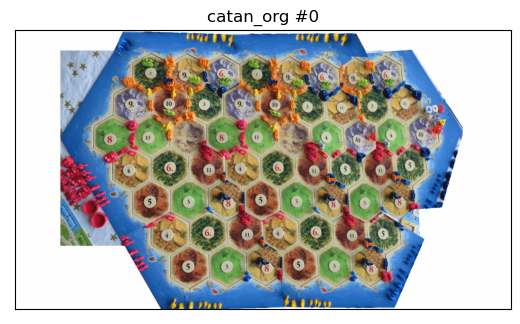

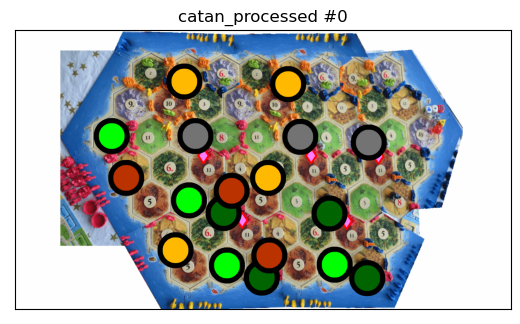

In [20]:

# Display images
for i in range(len(processed_images)):
    show_rgb_image(images[i], 'catan_org #' + str(i))
    show_rgb_image(processed_images[i], 'catan_processed #' + str(i))
cv2.destroyAllWindows()
